# AMath 586 Homework 3

###Brian de Silva

###Problem 3 - Bogacki-Shampine Runge-Kutta method

In [58]:
# Step 1: Single timestep with B-S method

# Perform one step of B-S method with timestep k (u'(t) = f(t,u), u(t_0) = u_0)
function singleBSStep(f,u_0,t_0,k)
    k₁ = f(t_0,u_0);
    k₂ = f(t_0 + k/2, u_0 + (k*k₁)/2);
    k₃ = f(t_0 + (3/4)*k, u_0 + (3*k*k₂)/4);
    u_hat = u_0 + (2*k*k₁)/9 + (k*k₂)/3 + (4*k*k₃)/9;           # Third order approximation
    k₄ = f(t_0 + k, u_hat);
    u = u_0 + (7*k*k₁)/24 + (k*k₂)/4 + (k*k₃)/3 + (k*k₄)/8; # Second order approximation
    return (u_hat,u)
end

# This f corresponds to u' = lambdau, which has exact solution u(t) = exp(lambdat),
# for IC u(0) = 1.
lambda = -3;
f = (t,u) -> lambda * u;

# Print ratio between absolute errors of the two approximations as stepsize is halved
(u_hat,u) = singleBSStep(f,1,0,1/2);
u_hat_prev_err = abs(u_hat - exp(lambda/2));
u_prev_err = abs(u - exp(lambda/2));

err2ord = Float64[];
err3ord = Float64[];
for j=2:10
    k = 2.0^(-j);
    (u_hat,u) = singleBSStep(f,1,0,k);
    u_hat_err = abs(u_hat - exp(k * lambda));
    u_err = abs(u - exp(k * lambda));
    push!(err2ord,u_prev_err / u_err);
    push!(err3ord,u_hat_prev_err / u_hat_err);
    u_hat_prev_err = u_hat_err;
    u_prev_err = u_err;
end
println("Third order method error ratio as stepsize is halved:")
for ratio in err3ord
    println(ratio)
end

println("\nSecond order method error ratio as stepsize is halved:")
for ratio in err2ord
    println(ratio)
end

Third order method error ratio as stepsize is halved:
14.05454710800195
14.923526422174445
15.432261325423378
15.70824783875262
15.852085435630233
15.925524350789642
15.96263042156919
15.981287767341858
15.99051823972206

Second order method error ratio as stepsize is halved:
9.208203329622291
9.381371574197148
9.010134912108915
8.613245882907943
8.338703950904382
8.178138161436115
8.091371860291467
8.04627568271947
8.02328670442059


This output suggests that the "second order" part of the method is in fact third order and the "third order" part is fourth order if we only take one time step from the initial time, at least on the test problem $u' = \lambda u.$

In [59]:
# Step 2: Fixed time step B-S

# Computes third order accurate approximation to solution of 
# u'(t) = f(t,u), with IC u(t_0) = u_0 up to time T using N timesteps,
# i.e. tₙ = t_0 + k*n, Uⁿ ≈ u(tₙ), k = T/N, UN ~ u(T).
function fixedStepBS(f,u_0,t_0,N,T)
    k = T/N
    U = zeros(N+1);
    U[1] = u_0;
    
    # Prime k4 for use in the first iteration
    k4 = f(t_0,U[1]);
    for n=2:N+1
        t_n = t_0 + k*(n-2);
        # Reuse final stage from prev. iteration
        k1 = k4;
        k2 = f(t_n + k/2, U[n-1] + (k*k1)/2);
        k3 = f(t_n + (3/4)*k, U[n-1] + (3*k*k2)/4);
        # Third order approximation
        U[n] = U[n-1] + (2*k*k1)/9 + (k*k2)/3 + (4*k*k3)/9;
        k4 = f(t_n + k, U[n]);                                         
        # Second order approximation
        U_2ord = U[n-1] + (7*k*k1)/24 + (k*k2)/4 + (k*k3)/3 + (k*k4)/8;
    end
    return U
end


# This f corresponds to u' = lambdau, which has exact solution u(t) = exp(lambdat),
# for IC u(0) = 1.
lambda = -3;
f = (t,u) -> lambda * u;


# Print ratio between absolute error at T as the stepsize is halved
T = 10
U = fixedStepBS(f,1,0,10,T);
U_prev_err = abs(U[end] - exp(lambda*T));
fixedsteperr = Float64[];
for j=2:10
    N = convert(Int64,2.0^(j) * 5);
    U = fixedStepBS(f,1,0,N,T);
    U_err = abs(U[end] - exp(lambda*T));
    push!(fixedsteperr,U_prev_err/U_err);
    U_prev_err = U_err;
end

println("Error ratio as stepsize is halved:")
for ratio in fixedsteperr
    println(ratio);
end

Error ratio as stepsize is halved:
1.094294997157778e16
1.6010731121185087
7.319503958662112
8.951853052317007
8.589898214653301
8.302380172440731
8.151116475854781
8.075338974332153
8.03759208291063


This output suggests the method achieving third order accuracy on the test problem $u' = \lambda u$.

In [60]:
# Step 3 Adaptive time method

# Import plotting package
using PyPlot;

# Computes a (hopefully!) second order accurate approximation to solution of 
# u'(t) = f(t,u), with IC u(t_0) = u_0 up to time T using adaptive timestepping (k_0 = initial time step)
# Attempts to bound absolute error |Uᴺ - u(T)| < epsilon (using Bogacki-Shampine method)
function adaptiveStepBS(f,u_0,t_0,k_0,T,epsilon)
    k_max = 10*(epsilon)^(1/3);
    k = k_0
    U = Float64[];
    push!(U,u_0);
    tVec = Float64[];
    push!(tVec,t_0)
    
    # Prime k4 for use in the first iteration
    k4 = f(t_0,U[1]);
    n = 2;
    while tVec[end] < T
        t_n = tVec[n-1];
        push!(tVec,t_n + k);
        # Reuse final stage from prev. iteration
        k1 = k4;
        k2 = f(t_n + k/2, U[n-1] + (k*k1)/2);
        k3 = f(t_n + (3/4)*k, U[n-1] + (3*k*k2)/4);
        # Third order approximation
        push!(U, U[n-1] + (2*k*k1)/9 + (k*k2)/3 + (4*k*k3)/9);
        k4 = f(t_n + k, U[n]);                                         
        # Second order approximation
        U_2ord = U[n-1] + (7*k*k1)/24 + (k*k2)/4 + (k*k3)/3 + (k*k4)/8;
        
        # Choose next time step
        C = abs(U[n] - U_2ord) / (k^3);
        k_new = sqrt(epsilon / (C*(T-t_0)));
        
        # Make sure new k isn't too large
        if k_new > k_max
            k_new = k_max;
        end
        
        # Make sure we don't overshoot the final time T
        if T - t_n - k < k_new
            k_new = T - t_n - k
        end
        k = k_new;
        
        n += 1;
    end
    return (U,tVec)
end;

Error: 1.0902762976439107e-5
Used 330 time steps


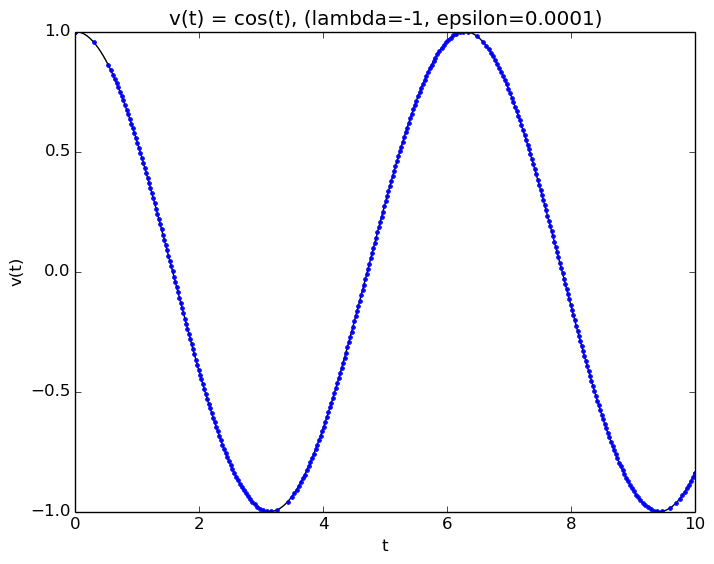

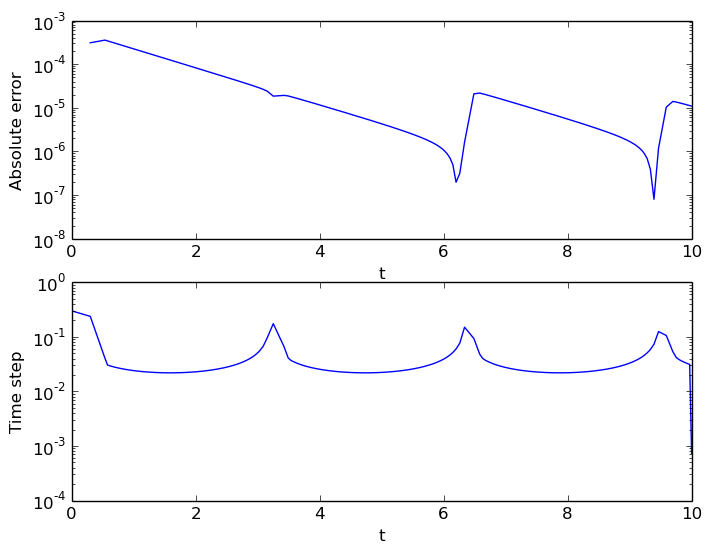

In [69]:
#  Solve problems of the form u'(t) = lambda(u - v(t)) + v'(t)

# Problem 3(a): v(t) = cos(t), lambda=-1
lambda = -1;
v = t -> cos(t);
v_prime = t -> -sin(t);
T = 10;
f = (t,u) -> lambda*(u - v(t)) + v_prime(t);
epsilon = 1e-4;


# # Print LateX-friendly error and time steps used
# errVec = Float64[]
# iterVec = Int64[]
# for m=2:10
#     (U,tVec) = adaptiveStepBS(f,1,0,1e-4,T,1/(10^m))
#     push!(errVec,abs(U[end] - v(T)));
#     push!(iterVec,size(tVec)[1]);
# end
# for k=1:size(iterVec)[1]
#     println("\$10^{-$(k+1)}\$ & $(errVec[k]) & $(iterVec[k]) \\\\ \\hline")
# end


# Print absolute error at time T and total number of time steps
(U,tVec) = adaptiveStepBS(f,1,0,1e-4,T,epsilon);
println("Error: $(abs(U[end] - v(T)))");
println("Used $(size(tVec)[1]) time steps")

# Plot exact solution vs. approximation;
PyPlot.figure();
PyPlot.plot(linspace(0,T,10000),v(linspace(0,T,10000)),"k-");
PyPlot.plot(tVec, U, "b.");
PyPlot.xlabel("t");
PyPlot.ylabel("v(t)");
PyPlot.title("v(t) = cos(t), (lambda=$lambda, epsilon=$epsilon)");

# Plot Error and time step size
PyPlot.figure();
PyPlot.subplot(2,1,1)
PyPlot.semilogy(tVec, abs(v(tVec) - U), "b-")
PyPlot.ylabel("Absolute error")
PyPlot.xlabel("t")
PyPlot.subplot(2,1,2)
PyPlot.semilogy(tVec[1:end-1],tVec[2:end] - tVec[1:end-1],"b-");
PyPlot.ylabel("Time step")
PyPlot.xlabel("t");

Error: 0.0017645787780279365
Used 710 time steps


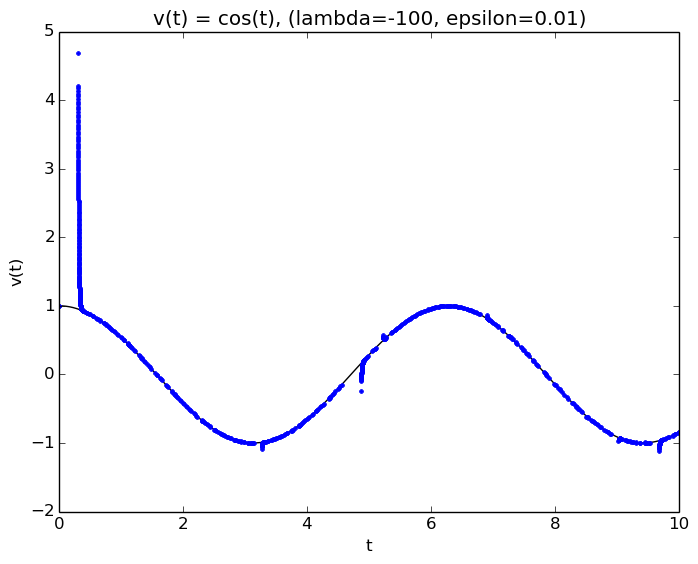

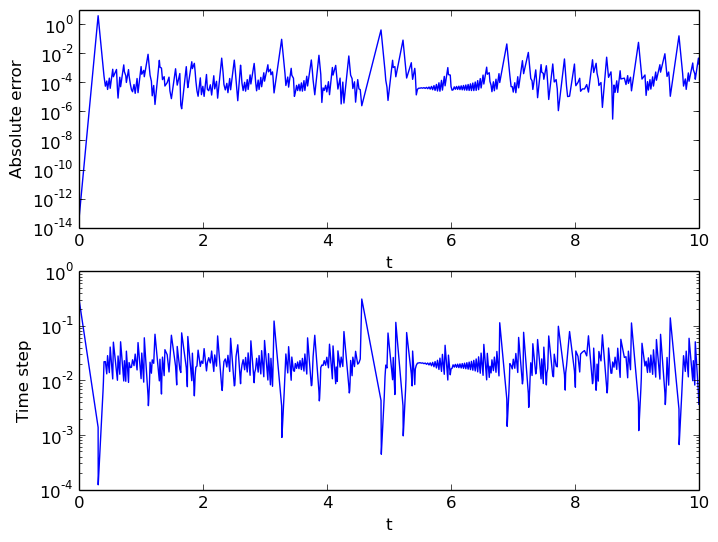

In [67]:
# Problem 3(b): v(t) = cos(t), lambda<-1
lambda = -100;
v = t -> cos(t);
v_prime = t -> -sin(t);
T = 10;
f = (t,u) -> lambda*(u - v(t)) + v_prime(t);
epsilon = 1e-2;

# # Print LateX-friendly error and time steps used
# errVec = Float64[]
# iterVec = Int64[]
# for m=2:10
#     (U,tVec) = adaptiveStepBS(f,1,0,1e-4,T,1/(10^m))
#     push!(errVec,abs(U[end] - v(T)));
#     push!(iterVec,size(tVec)[1]);
# end
# for k=1:size(iterVec)[1]
#     println("\$10^{-$(k+1)}\$ & $(errVec[k]) & $(iterVec[k]) \\\\ \\hline")
# end


# Print absolute error at time T and total number of time steps
(U,tVec) = adaptiveStepBS(f,1,0,1e-4,T,epsilon);
println("Error: $(abs(U[end] - v(T)))");
println("Used $(size(tVec)[1]) time steps")

# Plot exact solution vs. approximation;
PyPlot.figure();
PyPlot.plot(linspace(0,T,10000),v(linspace(0,T,10000)),"k-");
PyPlot.plot(tVec, U, "b.");
PyPlot.xlabel("t");
PyPlot.ylabel("v(t)");
PyPlot.title("v(t) = cos(t), (lambda=$lambda, epsilon=$epsilon)");

# Plot Error and time step size
PyPlot.figure();
PyPlot.subplot(2,1,1)
PyPlot.semilogy(tVec, abs(v(tVec) - U), "b-")
PyPlot.ylabel("Absolute error")
PyPlot.xlabel("t")
PyPlot.subplot(2,1,2)
PyPlot.semilogy(tVec[1:end-1],tVec[2:end] - tVec[1:end-1],"b-");
PyPlot.ylabel("Time step")
PyPlot.xlabel("t");

Error: 0.0029402070388248047
Used 164 time steps


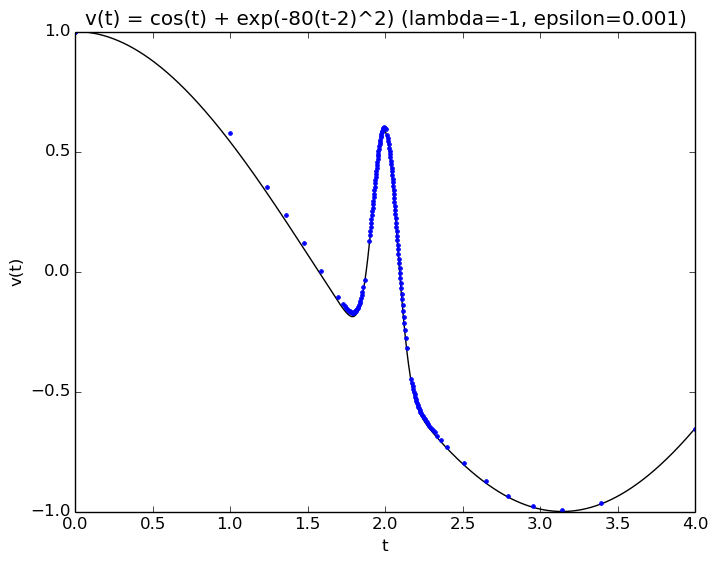

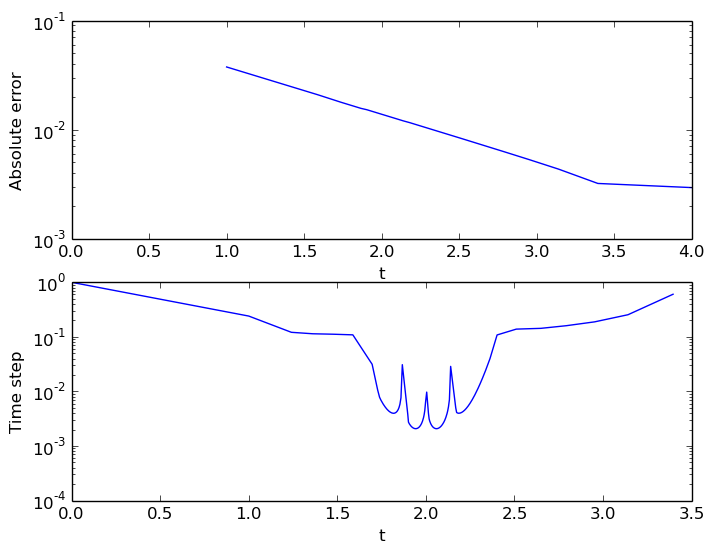

In [68]:
# Problem 3(c): v(t) = cos(t) + exp(-80(t-2)^2)
lambda = -1;
v = t -> cos(t) + exp(-80 * (t-2).^2);
v_prime = t-> -sin(t) - 160*(t-2)*exp(-80 * (t-2)^2);


f = (t,u) -> lambda*(u - v(t)) + v_prime(t);
T = 4;
epsilon = 1e-3;


# Print LateX-friendly error and time steps used
# errVec = Float64[]
# iterVec = Int64[]
# for m=2:10
#     (U,tVec) = adaptiveStepBS(f,1,0,1e-4,T,1/(10^m))
#     push!(errVec,abs(U[end] - v(T)));
#     push!(iterVec,size(tVec)[1]);
# end
# for k=1:size(iterVec)[1]
#     println("\$10^{-$(k+1)}\$ & $(errVec[k]) & $(iterVec[k]) \\\\ \\hline")
# end

# Print absolute error at time T and total number of time steps
(U,tVec) = adaptiveStepBS(f,1,0,1e-4,T,epsilon);
println("Error: $(abs(U[end] - v(T)))");
println("Used $(size(tVec)[1]) time steps")

# Plot exact solution vs. approximation;
PyPlot.figure();
PyPlot.plot(linspace(0,T,10000),v(linspace(0,T,10000)),"k-");
PyPlot.plot(tVec, U, "b.");
PyPlot.xlabel("t");
PyPlot.ylabel("v(t)");
PyPlot.title("v(t) = cos(t) + exp(-80(t-2)^2) (lambda=$lambda, epsilon=$epsilon)");


# Plot Error and time step size
PyPlot.figure();
PyPlot.subplot(2,1,1)
PyPlot.semilogy(tVec, abs(v(tVec) - U), "b-")
PyPlot.ylabel("Absolute error")
PyPlot.xlabel("t")
PyPlot.subplot(2,1,2)
PyPlot.semilogy(tVec[1:end-1],tVec[2:end] - tVec[1:end-1],"b-");
PyPlot.ylabel("Time step")
PyPlot.xlabel("t");